In [41]:
import time
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

import requests
import matplotlib.pyplot as plt
import seaborn as sns

### Спарсим данные, сохраним полученные датафреймы и будем в случае чего обращаться к локально сохраненным данным

In [42]:
# Парсер для получения данных с westmetall
def parser(metall_str: str):
    url = f'https://www.westmetall.com/en/markdaten.php?action=table&field=LME_{metall_str}_cash'
        
    response = requests.get(url=url)
    
    # преобразуем ответ в датафрейм
    df_2023 = pd.read_html(response.text)[0]
    df_2022 = pd.read_html(response.text)[1]
    df_2021 = pd.read_html(response.text)[2]
    df_2020 = pd.read_html(response.text)[3]
    df_2019 = pd.read_html(response.text)[4]
    df_2018 = pd.read_html(response.text)[5]
    df_2017 = pd.read_html(response.text)[6]
    df_2016 = pd.read_html(response.text)[7]
    df_2015 = pd.read_html(response.text)[8]
    
    df = pd.concat([
        df_2023, df_2022, df_2021, 
        df_2020, df_2019, df_2018, 
        df_2017, df_2016, df_2015
    ]
    )
    
    # очищаем таблицу от неинформативных строк
    cleared_df = df[df['date'] != 'date']
    # заменяем символы пропусков нулями
    cleared_df = cleared_df.replace('-', 0)
    
    # приобразуем типы данных
    cleared_df['date'] = pd.to_datetime(cleared_df['date'])
    # т.к. столбцы имеют разное назание, обращяемся по индексу
    cleared_df.iloc[:,1] = pd.to_numeric(
        cleared_df.iloc[:,1])

    cleared_df.iloc[:,2] = pd.to_numeric(
        cleared_df.iloc[:,2])
    # в данном столбце, за счет использования символа запятой
    # для разделения целой части от дробной,
    # pandas не корректно преобразовал значения
    cleared_df.iloc[:,3] = pd.to_numeric(
        cleared_df.iloc[:,3]) / 1000
    
    return cleared_df.set_index('date')

# Список источников, нам понадобится информация по 5 видам сырья:
# алюминий, медь, свинец, никель и цинк
metalls = ['Al', 'Cu', 'Pb', 'Ni', 'Zn']

# Иниуиируем датафреймы, делая паузу после исполнения, для обхода
# возможной блокировки со стороны источника
#al_df = parser(metalls[0])
#time.sleep(1)
cu_df = parser(metalls[1])
#time.sleep(1)
#pb_df = parser(metalls[2])
#time.sleep(1)
#ni_df = parser(metalls[3])
#time.sleep(1)
#zn_df = parser(metalls[4])

In [55]:
# Выведем полученные данные и сохраним как бекап.
#al_df.to_csv('./data/aluminium.csv', sep=',')
cu_df.to_csv('./data/copper.csv', sep=',')
#pb_df.to_csv('./data/lead.csv', sep=',')
#ni_df.to_csv('./data/nickel.csv', sep=',')
#zn_df.to_csv('./data/zink.csv', sep=',')

display(cu_df.head(), cu_df.head())

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-11,8332.5,8360.0,134.525
2023-09-08,8225.0,8242.0,134.125
2023-09-07,8242.5,8270.0,133.85
2023-09-06,8395.0,8412.0,110.4
2023-09-05,8430.0,8430.0,107.4


,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-11,8332.5,8360.0,134.525
2023-09-08,8225.0,8242.0,134.125
2023-09-07,8242.5,8270.0,133.85
2023-09-06,8395.0,8412.0,110.4
2023-09-05,8430.0,8430.0,107.4


In [ ]:
# Парсер шанхайской биржи металлов


----

In [44]:
data = pd.read_csv('./data/copper.csv', parse_dates=['date'], index_col='date')
data = data.sort_index()
data


,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2015-01-02,6309.0,6247.0,177.025
2015-01-05,6216.0,6150.0,178.425
2015-01-06,6191.0,6121.0,178.775
2015-01-07,6170.0,6105.0,178.675
2015-01-08,6230.5,6160.5,179.225
...,...,...,...
2023-09-05,8430.0,8430.0,107.400
2023-09-06,8395.0,8412.0,110.400
2023-09-07,8242.5,8270.0,133.850


In [45]:
df_cu = data['LME Copper stock']
df_cu = df_cu.resample('d').interpolate(method='linear')

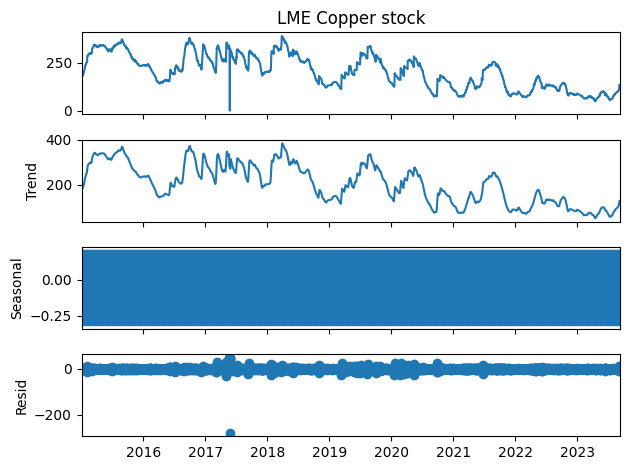

In [46]:
decomposition = seasonal_decompose(df_cu)
fig = decomposition.plot()
plt.show()

In [40]:
train_data = df_cu.loc['2019-01-02':'2023-05-31']
test_data = df_cu.loc['2023-06-01':]

train_data = train_data.sort_index()
test_data = test_data.sort_index()

train_data['LME Copper Cash-Settlement'] = pd.to_numeric(train_data['LME Copper Cash-Settlement'], errors='coerce')
train_data['LME Copper 3-month'] = pd.to_numeric(train_data['LME Copper 3-month'], errors='coerce')
train_data['LME Copper stock'] = pd.to_numeric(train_data['LME Copper stock'], errors='coerce')

test_data['LME Copper Cash-Settlement'] = pd.to_numeric(test_data['LME Copper Cash-Settlement'], errors='coerce')
test_data['LME Copper 3-month'] = pd.to_numeric(test_data['LME Copper 3-month'], errors='coerce')
test_data['LME Copper stock'] = pd.to_numeric(test_data['LME Copper stock'], errors='coerce')

KeyError: 'LME Copper Cash-Settlement'

In [229]:
# Создание и обучение модели ARIMA
model = ARIMA(train_data.iloc[:,2], order=(1, 0, 1))
model_fit = model.fit()

# Прогнозирование значений
forecast = model_fit.forecast(steps=len(test_data.iloc[:,2]))

# Оценка точности прогноза
mse = np.mean((forecast - test_data.iloc[:,2]) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(forecast - test_data.iloc[:,2]))

# Вывод результатов
print("RMSE:", rmse)
print("MAE:", mae)

RMSE: nan
MAE: nan


In [230]:
forecast

1113     99.246720
1114     99.587282
1115     99.925784
1116    100.262238
1117    100.596656
           ...    
1180    118.052365
1181    118.279155
1182    118.504572
1183    118.728625
1184    118.951323
Name: predicted_mean, Length: 72, dtype: float64

In [231]:
test_data

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-06-01,8210.5,8227.0,99.525
2023-06-02,8337.0,8345.0,98.675
2023-06-05,8265.0,8263.0,98.950
2023-06-06,8311.0,8322.0,99.825
2023-06-07,8352.0,8354.0,100.100
...,...,...,...
2023-09-05,8430.0,8430.0,107.400
2023-09-06,8395.0,8412.0,110.400
2023-09-07,8242.5,8270.0,133.850
